In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# models
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression


# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# evaluation 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score

# Creating Dummy Dataset for Prototyping
---
Pass if:
- flow_metric is between 9 and 11 µL/min
- pressure drop is between 85 and 115 Pascals

In [29]:
data = pd.read_csv('datasets/Updated_Dataset_with_Post-Print_Deviations.csv')

# Data Preprocessing
---
- turn resin type into one hot vector
- standardize all data
- split into X and y
- split into train and test data

In [53]:
X_all = data.drop(columns=["model_id", "flow_metric"])
y_all = data['flow_metric'] # regression, dont need pass_fail feature 

# split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Surrogate Model 
---

In [70]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)   # no warning, scaling handled automatically

In [71]:
mae = mean_absolute_error(y_test, lr_pred)
mse = mean_squared_error(y_test, lr_pred)
rmse = np.sqrt(mse) # Calculate RMSE manually
r2 = r2_score(y_test, lr_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 22.33
Mean Squared Error (MSE): 860.35
Root Mean Squared Error (RMSE): 29.33
R-squared (R²): 0.96


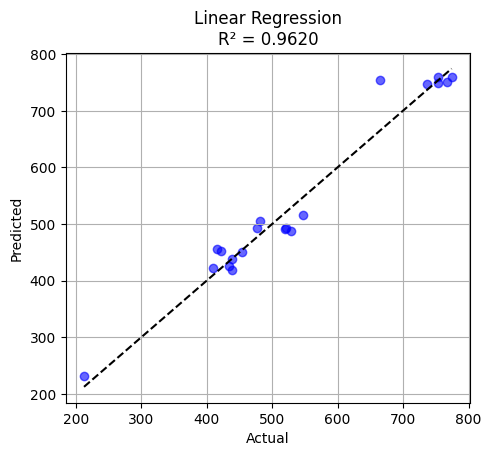

In [72]:
plt.figure(figsize=(24, 10))

# 1. Linear Regression
plt.subplot(2, 4, 1)
plt.scatter(y_test, lr_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Linear Regression\nR² = {r2_score(y_test, lr_pred):.4f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

In [80]:
# surrogate model
# gpr = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("model", GaussianProcessRegressor(alpha=1e-6, normalize_y=True))
# ])

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1.0))

gpr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=10,
        alpha=1e-10,
        random_state=42,
    )),
])

gpr.fit(X_train, y_train)
gpr_pred = gpr.predict(X_test)

In [81]:
mae = mean_absolute_error(y_test, gpr_pred)
mse = mean_squared_error(y_test, gpr_pred)
rmse = np.sqrt(mse) # Calculate RMSE manually
r2 = r2_score(y_test, gpr_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 21.77
Mean Squared Error (MSE): 725.87
Root Mean Squared Error (RMSE): 26.94
R-squared (R²): 0.97


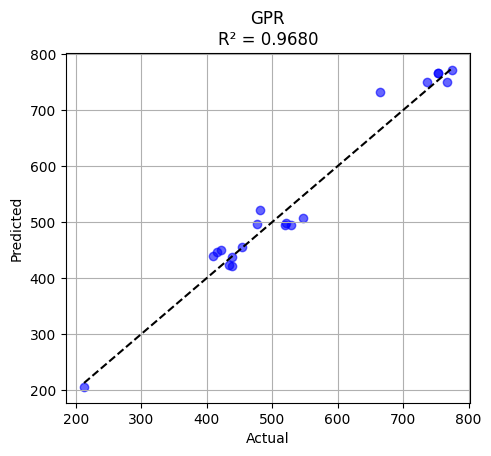

In [79]:
# 2. GPR
plt.figure(figsize=(24, 10))

plt.subplot(2, 4, 1)
plt.scatter(y_test, gpr_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'GPR\nR² = {r2_score(y_test, gpr_pred):.4f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)